# Training Surrogates

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/examples/surrogate_notebook.ipynb)

This notebook demonstrates how to generate data using a Susceptible-Infected-Recovered (SIR) model with the `emidm` package. The generated data can be used to train deep learning surrogates for infectious disease modeling.

The first two sections (`Generate Simulation Data` and `Prepare Training Dataset`) make use of `emidm` to generate our training data and are provided in brief to show what data is being generated and to ease into the notebook. The next three sections introduce how to train your surrogate model, validate this and explore ways of using this.

The last section are possible extensions for those who finish early, which ask you to think about tweaking the code used to test your understanding about how surrogates are trained, or to explore how to use them further analysis.

## Objectives

- Simulate SIR model dynamics using the `emidm` package.
- Generate multiple realizations of the model with varying parameters.
- Prepare the simulated data for training deep learning surrogates.
- Train different surrogate models and compare these
- Visualise performance of surrogates

## Enabling GPU Acceleration

To utilize GPUs for faster training of our neural networks, we need to change the runtime type in your Colab notebook or similar cloud-based environments. Here are the general steps:

1. Navigate to Runtime Settings:
  - In Colab, go to "Runtime" > "Change runtime type."
  - In other environments, look for similar options in the settings or configuration menu.

2. Select Hardware Accelerator:
  - Choose "GPU" from the "Hardware accelerator" dropdown menu.

3. Save and Restart Runtime:
  - Click "Save" to apply the changes. This will usually restart the runtime environment.

4. Verify GPU Availability:
  - After the restart, you can run a code snippet like this to confirm that the GPU is recognized and accessible.
  - You do not need to do this as we will check this later, but if you want to (and want to practice adding a code cell then plaese do
  
```python
import torch

     if torch.cuda.is_available():
         print("GPU is available!")
         print(f"Using device: {torch.cuda.get_device_name(0)}")
     else:
         print("GPU is not available. Using CPU.")
```


## Prerequisites

We will be using the helper functions in the `emidm` package, which will be installed and all relevant modules from this as well as other required packages loaded below in two steps.

First we will install `emidm` from Github:

In [81]:
%pip install git+https://github.com/OJWatson/emidm.git

  Cloning https://github.com/OJWatson/emidm.git to /tmp/pip-req-build-secuzpuu
  Running command git clone --filter=blob:none --quiet https://github.com/OJWatson/emidm.git /tmp/pip-req-build-secuzpuu
  Resolved https://github.com/OJWatson/emidm.git to commit 5ff8e7b0e20516e5143e48dbbc3f0279e8943414
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Next we will import any required modules once here. If this works then the rest of the notebook should work 🤞:

In [82]:
# Imports from our own package
from emidm.sir import run_sir, run_model_with_replicates, plot_model_outputs
from emidm.sampler import generate_lhs_samples

# imports of other common packages
import pandas as pd
import numpy as np
import random
import os
import json
import matplotlib.pyplot as plt

# for those who like me prescrbe to Hadley Wickham's one truth of a grammar of graphics
from plotnine import ggplot, aes, geom_line, facet_wrap

# for providing times on notebook for loops
from tqdm.notebook import tqdm

# Import necessary libraries for neural networks and ML aspect
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

## 1. Generate Simulation Data

### Running a Single SIR Model Simulation

We can use `emidm` to ssimulate the SIR model dynamics using default parameters:

In [83]:
# Demonstrate running one model
single = run_sir()

# Show the output
single

,t,N,S,I,R
0,0,1000,990,10,0
1,1,1000,989,11,0
2,2,1000,987,12,1
3,3,1000,987,12,1
4,4,1000,983,16,1
...,...,...,...,...,...
96,96,1000,198,13,789
97,97,1000,198,9,793
98,98,1000,198,9,793
99,99,1000,198,7,795


The output is a `pandas DataFrame` containing the number of susceptible (S), infected (I), and recovered (R) individuals over time.

To visualize the results:

<Axes: xlabel='t'>

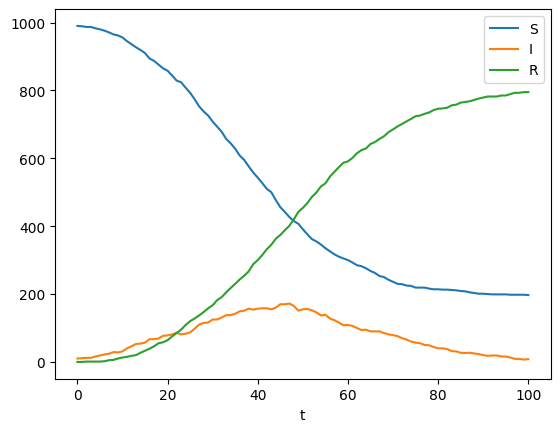

In [84]:
# Show a single plot line
single.plot("t", ["S", "I", "R"])


We can adjust parameters such as the transmission rate (`beta`) to observe different dynamics:

<Axes: xlabel='t'>

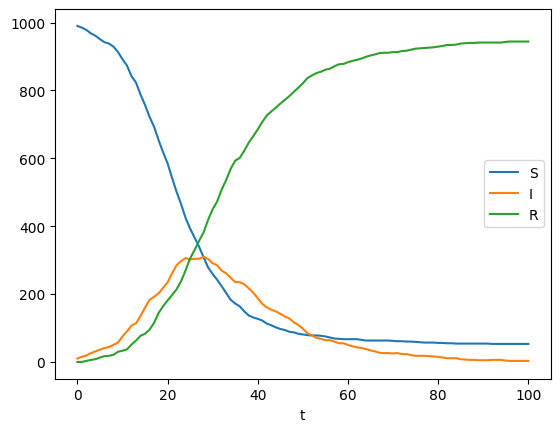

In [85]:
# We can also vary the parameters
alt = run_sir(beta = 0.3)
alt.plot("t", ["S", "I", "R"])

### Running Multiple Stochastic Realisations

To account for stochasticity, we can run multiple realizations of the model:

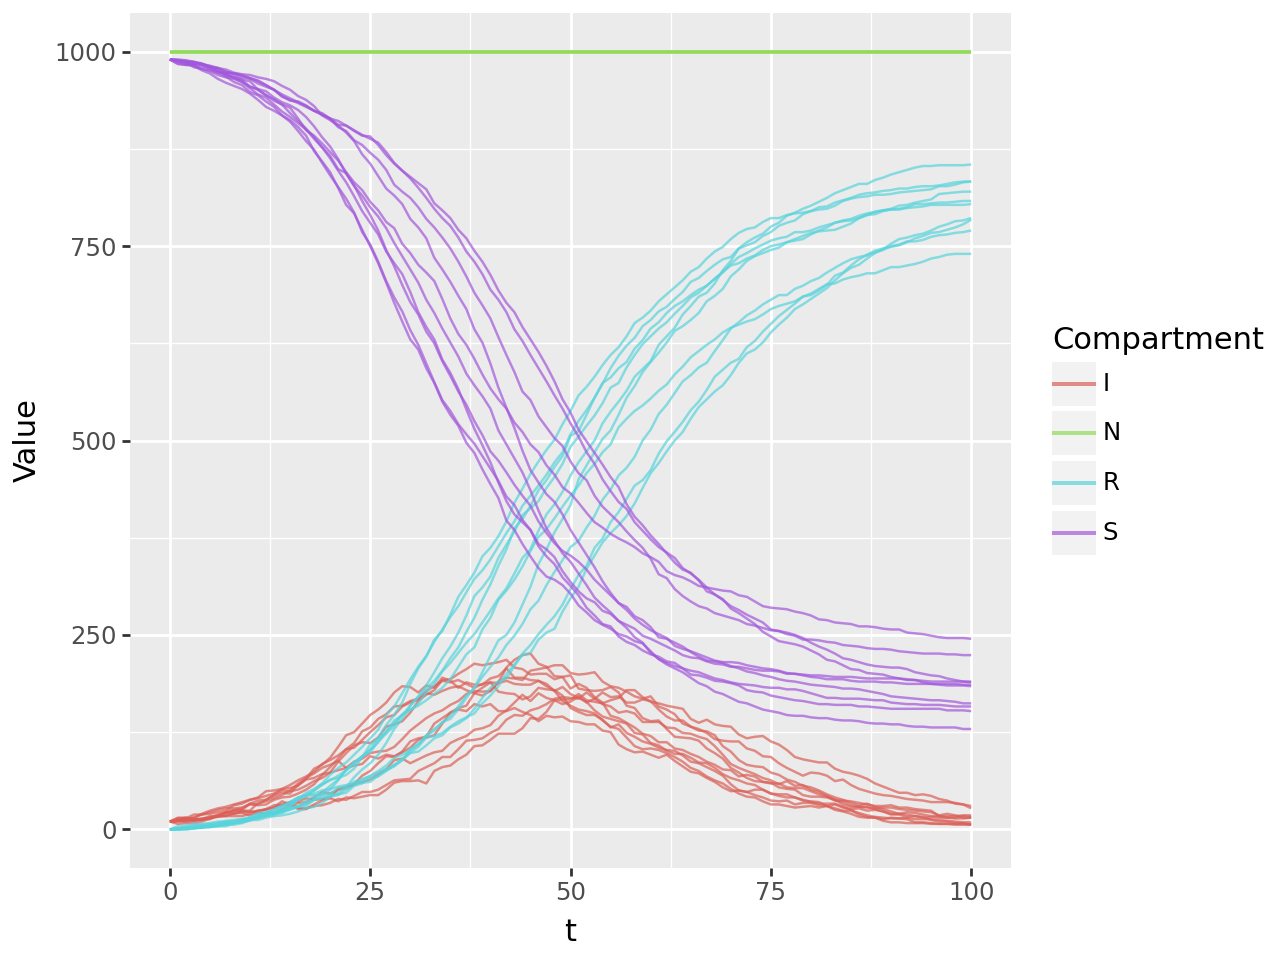

In [86]:
# we can run multiple realisations
reps = run_model_with_replicates(model = run_sir, reps = 10)

# and plot these
p = plot_model_outputs(reps)

And we can also pass through any of the arguments to `run_sir` to our `run_model_with_replicates` function.

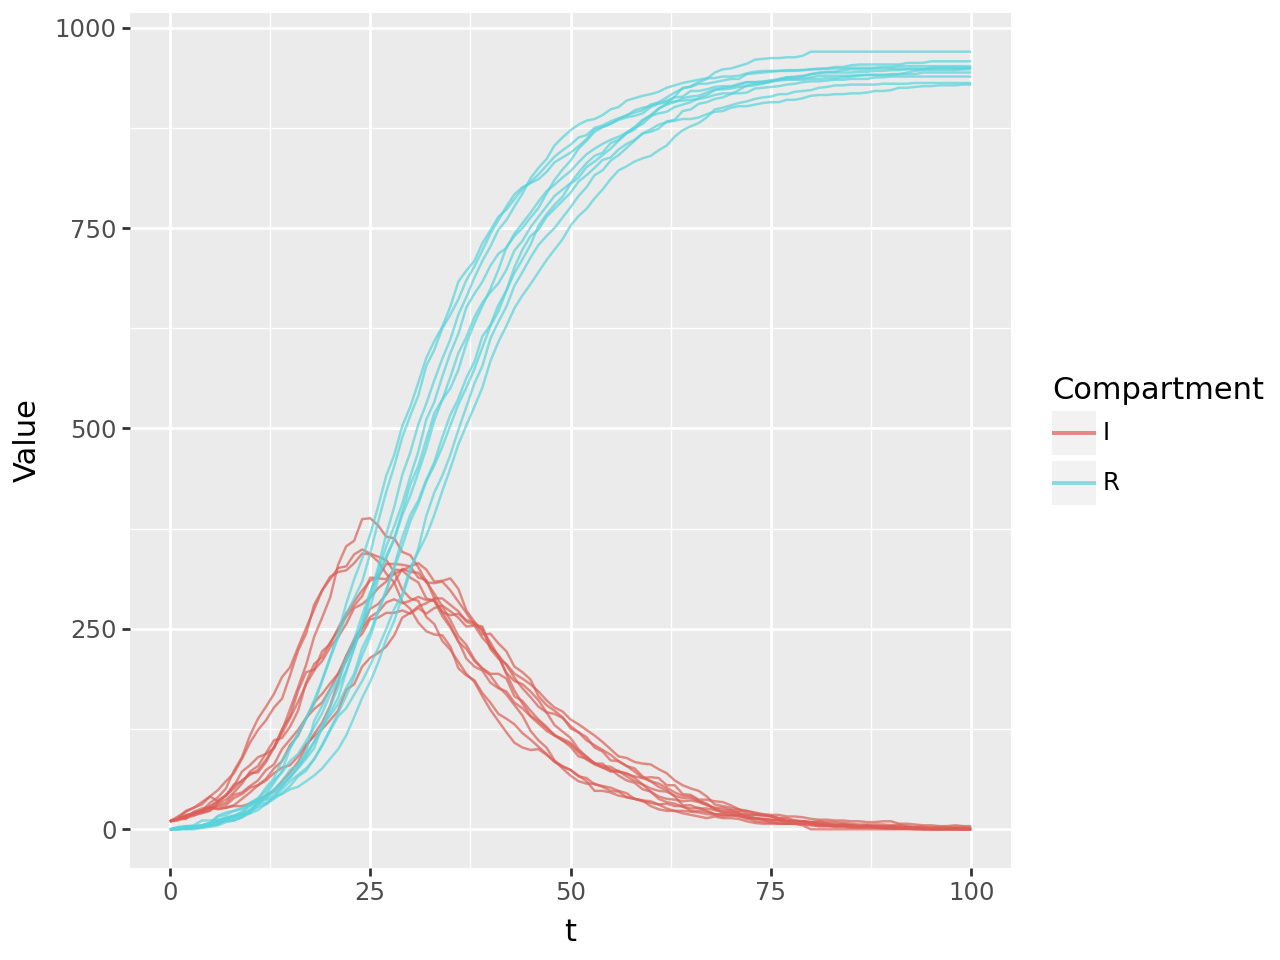

In [87]:
# we can also by args to run_sir through kwargs
reps = run_model_with_replicates(model=run_sir, reps=10, beta = 0.3)

# and plot these
p = plot_model_outputs(reps, columns = ["I", "R"])

## 2. Prepare Training Dataset

### Sampling Parameter Space with Latin Hypercube Sampling

To systematically explore the parameter space, we use Latin Hypercube Sampling (LHS), which we have again provided helper functions from `emidm` for you to use.


In [88]:
# now to generate a lhs sample based on R0 and gamma
def beta_gamma_from_r0_gamma(n_samples, param_ranges, seed = None):
    df_samples = generate_lhs_samples(param_ranges, n_samples=n_samples, seed=seed)
    df_samples = df_samples.assign(beta = lambda x: x["R0"] * x["gamma"])
    df_samples = df_samples.drop(columns=["R0"])
    return df_samples

param_ranges = {"R0": [1.1, 4], "gamma": [0.05, 0.25]}
df_samples = beta_gamma_from_r0_gamma(n_samples=9, seed=42, param_ranges = param_ranges)
df_samples

,gamma,beta
0,0.129136,0.401118
1,0.101170,0.148495
2,0.183875,0.374429
3,0.165865,0.569336
4,0.084436,0.198222
5,0.140516,0.409444
6,0.231716,0.878792
7,0.067172,0.172515
8,0.226360,0.281483


This generates a set of parameter combinations, which we can then pass to our `run_model_with_replicates` function. We have just used 9 samples here initially just to show you the outputs and understand it. Later we will generate more samples to build a robust training dataset.

In [89]:
# Run the model for each row of samples:
results = [
    run_model_with_replicates(**row.to_dict(), reps=10).assign(**row.to_dict())
    for _, row in df_samples.iterrows()
]

# Combine results into one DataFrame:
df_all_results = pd.concat(results, axis=0)

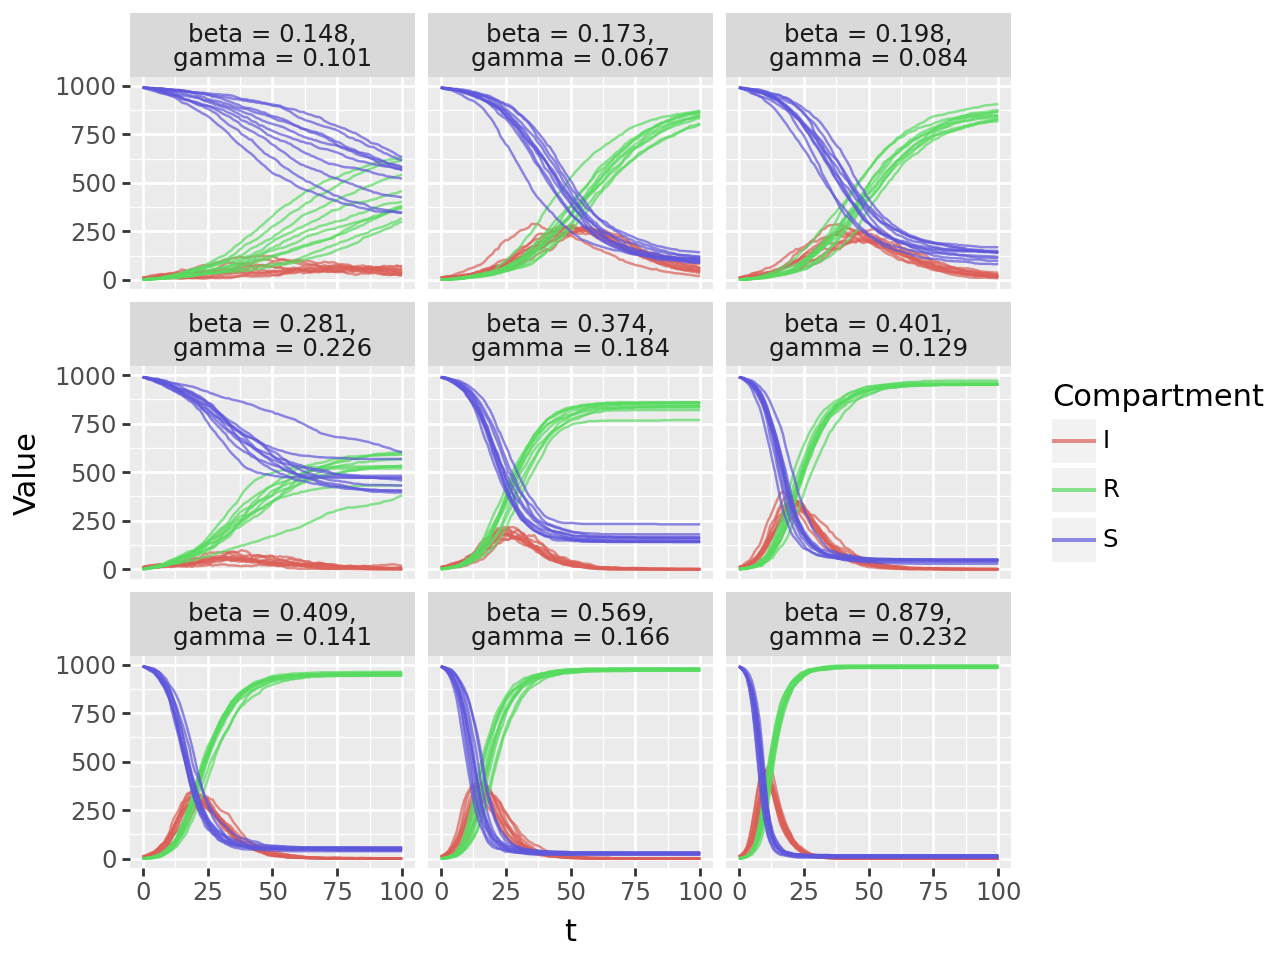

In [90]:
# Reshape dataframe into tidy long-format
df_long = df_all_results.melt(
    id_vars=["t", "replicate", "gamma", "beta"],
    value_vars=["S", "I", "R"],
    var_name="Compartment",
    value_name="Value",
)

# Add unique identifier for group plotting
df_long = df_long.assign(
    uid=df_long["Compartment"]
    + df_long["replicate"].astype(str)
)

# Add facet identifier for group plotting
df_long = df_long.assign(
    facet="beta = "
    + df_long["beta"].round(3).astype(str)
    + ",\n"
    + "gamma = "
    + df_long["gamma"].round(3).astype(str)
)

# Plot: color by compartment, lines grouped by replicate
p = (
    ggplot(
        df_long,
        aes(x="t", y="Value", group="uid", color="Compartment"),
    )
    + geom_line(alpha=0.7)
    + facet_wrap("facet")
)

# Explicitly plot
ggplot.show(p)

### Generating Training and Test Data

Now that we have seen how LHS is being used to sample different $\beta$ and $\gamma$ parameters and to generate simulations, we will now generate training, validation and test data in much the same way:   

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for saving models and plots
output_dir = "emulator_results"
os.makedirs(output_dir, exist_ok=True)

# larger training data
n_train = 1000
n_test = 200
n_valid = 100

# generate train samples and data
train_samples = beta_gamma_from_r0_gamma(n_samples=n_train, param_ranges = param_ranges)
train_data = pd.concat([
    run_model_with_replicates(**row.to_dict(), reps=5).assign(**row.to_dict())
    for _, row in tqdm(train_samples.iterrows(), total=len(train_samples))
], axis = 0)

# generate test samples
test_samples = beta_gamma_from_r0_gamma(n_samples=n_test, param_ranges = param_ranges)
test_data = pd.concat([
    run_model_with_replicates(**row.to_dict(), reps=5).assign(**row.to_dict())
    for _, row in tqdm(test_samples.iterrows(), total = len(test_samples))
], axis = 0)

# generate valid samples
valid_samples = beta_gamma_from_r0_gamma(n_samples=n_valid, param_ranges = param_ranges)
valid_data = pd.concat([
    run_model_with_replicates(**row.to_dict(), reps=5).assign(**row.to_dict())
    for _, row in tqdm(valid_samples.iterrows(), total = len(valid_samples))
], axis = 0)

  0%|          | 0/1000 [00:00<?, ?it/s]

## 3. Train a neural network

### Creating Dataset Class and Dataloader

While we have generated our training and test data, we need to prepare it into a PyTorch dataset and dataloader. The dataloader is a way of iterating through our data in batches, which is useful for training deep learning models. Batches are used to train the model in mini-batches, which is more efficient than training on the entire dataset at once. It also has the advantage of allowing us to use GPU acceleration if available.

We have not created this dataset class yet in `emidm`, so that we can show you how it works, so we will do that next. We will also use this an opportunity to learn a bit more about PyTorch and also how (more often) Python leverages classes.

In [ ]:
class SIRTimeSeriesDataset(Dataset):
    def __init__(self, dataframe, features=['beta', 'gamma'], targets=['S', 'I']):
        self.features = features
        self.targets = targets

        # Group by parameter sets
        self.grouped = dataframe.groupby(features + ['replicate'])
        self.param_sets = list(self.grouped.groups.keys())
        self.dataframe = dataframe

        # Extract timepoints (assuming they're the same for all parameter sets)
        self.timepoints = dataframe['t'].unique()
        self.time_length = len(self.timepoints)
        self.N = dataframe['N'].iloc[0]

        # Create samples
        self.samples = []
        for param_set in self.param_sets:
            df_group = self.grouped.get_group(param_set).sort_values('t')

            # Extract feature and target time series
            feature_values = np.array([param_set[features.index('beta')],
                                      param_set[features.index('gamma')]])

            # Extract full target time series
            target_series = np.column_stack([df_group[target].values / self.N for target in targets])

            # Store full time series with parameter info
            self.samples.append({
                'features': feature_values,
                'targets': target_series,
                'param_values': param_set
            })

        # Normalize input features
        feature_array = np.array([s['features'] for s in self.samples])
        self.feature_scaler = StandardScaler()
        self.feature_scaler.fit(feature_array)

        # No need to normalize S and I as they're already in [0,1] range

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Normalize features
        features_normalized = self.feature_scaler.transform(sample['features'].reshape(1, -1)).flatten()

        return torch.tensor(features_normalized, dtype=torch.float32), \
               torch.tensor(sample['targets'], dtype=torch.float32)

Having made our daa`SIRTimeSeriesDataset` class, we can use this to create a `SIRTimeSeriesDataset` object for each of our different data sets (train, validation, test).

After this we then create `DataLoaders`. This is a PyTorch class used to efficiently iterate through the datasets during training. It handles tasks like batching, shuffling (for the training set), and potentially loading data in parallel.

Batching controls the size of the data that will be fed to the model, which here we are doing in groups of 64 samples at a time.

In [ ]:
# Create datasets
train_dataset = SIRTimeSeriesDataset(train_data)
val_dataset = SIRTimeSeriesDataset(valid_data)
test_dataset = SIRTimeSeriesDataset(test_data)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


#### Batch Size Explained

In the code above, `batch_size` is set to 64. This means that during training, the model will see 64 samples of data before updating its internal parameters (weights and biases). This process of seeing a batch of data and then updating is called one **iteration**.

Instead of training on the entire dataset at once (which can be computationally expensive and memory-intensive), the data is divided into smaller batches. The model iterates through these batches, making adjustments to its parameters after seeing each batch.

##### *Why Use Batches?*

**1. Computational Efficiency:** Processing the entire dataset in one go can be very slow, especially for large datasets. Batches make the process more manageable by breaking it down into smaller steps. This is crucial for training deep learning models which often require vast amounts of data.

**2. Memory Management:** Loading the entire dataset into memory might not be feasible, especially when dealing with very large datasets or limited hardware resources. Batching allows the model to work with a smaller subset of the data at any given time, reducing memory requirements.

**3. Generalization:** Training on batches can improve the model's ability to generalize to unseen data. This is because the model is exposed to a variety of data points in each batch, preventing it from overfitting to specific examples in the training set. Updates based on a single data point at a time (e.g., with a batch size of 1 which is called stochastic gradient descent) could update the weights in a way that is not good for the model's prediction performance over all of the data. Using batches provides a better average for what data the model tends to see and thus better update performance.

**4. Noise Reduction:** The gradients (directions for updating model parameters) calculated on a batch are less noisy compared to those calculated on individual samples. This leads to more stable and smoother training, potentially helping the model converge faster to a good solution.

##### *Choosing the Right Batch Size*

The choice of batch size is a hyperparameter that can significantly impact the training process. There's no one-size-fits-all answer, and the optimal batch size often depends on factors like:

**1. Dataset Size:** Larger datasets can handle larger batch sizes, while smaller datasets might require smaller batches to avoid overfitting.
**2. Model Architecture:** Complex models with many parameters might benefit from larger batch sizes for better gradient estimations.
**3. Hardware:** Available memory and processing power influence the maximum batch size you can use.
**4. Training Time:** Larger batches can lead to faster training epochs (one pass through the entire dataset), but they might require more epochs to converge. Smaller batches require more iterations per epoch and are usually slower but are helpful in preventing issues like overfitting.

##### *In Practice:*

- Common Batch Sizes: 32, 64, 128, 256 are frequently used batch sizes.
- Experimentation: It's often necessary to experiment with different batch sizes to find the best one for a particular problem. You can evaluate performance on a validation set to guide your choice.

### Building Neural Network Models

This section of the code defines and trains three different types of neural networks to predict the Susceptible (S) and Infected (I) populations in the SIR model given the input parameters beta and gamma.

Before we delve into the specific model types, let's define some key terminology in neural networks:

- **Input Size:** The number of input features to the network. In this case, it's 2, representing beta and gamma.

- **Hidden Size:** The number of neurons in the hidden layers of the network. This controls the complexity and capacity of the model. A larger hidden size means the model can learn more complex patterns but might be prone to overfitting. Here, hidden_size is set to 64.

- **Output Size:** The number of output values the network produces. Here, it's 2, corresponding to the predicted S and I values.

- **Layers:** Neural networks consist of interconnected layers of neurons. Hidden layers process the input data and extract features, while the output layer produces the final predictions. Deeper networks (more hidden layers) can learn more complex relationships, but they are also more computationally intensive to train. This code uses hidden layers.

- **Dropout:** A regularization technique that helps prevent overfitting. During training, dropout randomly ignores a fraction of the neurons in a layer, forcing the network to learn more robust features that are not dependent on any single neuron. dropout_prob (set to 0.1 here) controls the probability of a neuron being dropped out.

In [ ]:
# Define constants
input_size = 2  # beta and gamma
hidden_size = 64
output_size = 2  # S and I
num_layers = 2
dropout_prob = 0.1

#### Feedforward Neural Network (FFNN)

This is the simplest type of neural network, where data flows in one direction from input to output. It has multiple layers, each containing a number of neurons (or units). It uses dropout for regularization, with a probability defined by dropout_prob that a neuron is ignored in a given step. It also has batch normalization and ReLU activation function for each hidden layer.

In our case, The FFNN model takes $\beta$ and $\gamma$ as input and aims to predict the time series of `S` and `I` values. Here's a simplified breakdown of how it works:

- **Input:** The input values (beta and gamma) are fed into the first layer of the network.

- **Hidden Layers:** The input values are processed through a series of hidden layers. Each layer consists of neurons that perform calculations on the input data using weights and biases.
  - The output of each neuron is passed through an activation function (ReLU here), which introduces non-linearity to the model.
  - Dropout is applied within the hidden layers to prevent overfitting.
  - Batch normalization is used to improve training stability and performance by normalizing the inputs to each layer.

- **Output Layer:** The final hidden layer's output is fed to the output layer, which produces the predictions for `S` and `I`. The output uses a sigmoid activation function, ensuring output values are between 0 and 1, representing the proportion of the population.

- **Training:** During training, the network's weights and biases are adjusted to minimize the difference between the predicted and actual `S` and `I` values (the loss). This adjustment is done using an optimization algorithm like Adam.

In [ ]:
# Feedforward Neural Network
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, time_steps, output_channels):
        super(FFNN, self).__init__()
        self.time_steps = time_steps
        self.output_channels = output_channels
        self.sigmoid = nn.Sigmoid()

        # Deeper network with dropout and batch normalization
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_size, hidden_size*2),
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_size*2, hidden_size*2),
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_size*2, time_steps * output_channels)
        )

    def forward(self, x):
        # Output shape: [batch_size, time_steps, output_channels]
        output = self.network(x)
        output = output.view(-1, self.time_steps, self.output_channels)
        output = self.sigmoid(output)  # Apply sigmoid
        return output

#### Gated Recurrent Unit (GRU)

This is a type of recurrent neural network (RNN) that is designed to handle sequential data, like the time series data from the SIR model. GRUs have a special mechanism called "gates" that help them learn long-term dependencies in the data. The key features of GRUs are:

- **Update Gate:** Decides how much past information to keep and how much to update.
- **Reset Gate:** Controls how much past information to ignore when computing the new state.
- **Hidden State:** Represents the current input and relevant past information.

**How it Works Here:**

- Inside the `forward` method of the `GRUModel`, this input vector is projected to a higher-dimensional space and then repeated for each time step to create a sequence (`x_seq`). This effectively creates a constant input sequence where the same `beta` and `gamma` values are presented to the GRU at each time step.

- The GRU layer then processes this input sequence, but its primary focus is on learning the temporal relationships within the output sequence (`S` and `I` over time). The hidden state of the GRU evolves based on both the input and the previous hidden state, capturing the dynamic changes in `S` and `I` as the SIR model progresses.


In [ ]:
# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob, num_layers=2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()

        # Project parameters to a sequence
        self.input_projection = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # GRU layer
        self.gru = nn.GRU(
            hidden_size, hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            batch_first=True
        )

        # Output layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        batch_size = x.size(0)
        time_steps = train_dataset.time_length

        # Create a sequence from the parameter input
        x_seq = self.input_projection(x).unsqueeze(1).repeat(1, time_steps, 1)

        # Process with GRU
        out, _ = self.gru(x_seq)
        out = self.ln(out)
        out = self.dropout(out)
        out = self.fc(out)

        # Apply sigmoid activation
        out = self.sigmoid(out)
        return out

#### Long Short-Term Memory (LSTM)
This is another type of RNN, closely related to GRUs, also designed to handle sequential data like the time series from the SIR model. LSTMs use a more complex gating mechanism than GRUs, involving three gates (input, forget, output) and a cell state, enabling them to learn long-term dependencies and handle vanishing gradients effectively. The key features of LSTMs are:

- **Input Gate:** Regulates the flow of new information into the cell state.
- **Forget Gate:** Controls what information to discard from the cell state.
- **Output Gate:** Determines what information from the cell state is outputted.
- **Cell State:** Acts as a memory unit, storing and carrying information across time steps.
- **Hidden State:** Represents the current output and is influenced by the cell state and the output gate.

**How it Works Here:**

Similar to the GRU, inside the forward method of the `LSTMModel`, the input vector is projected to a higher-dimensional space and repeated for each time step to form a sequence (`x_seq`). This creates a constant input sequence where the same beta and gamma values are presented to the LSTM at each time step.

The LSTM layer processes this input sequence, but its primary focus is on learning the temporal relationships within the output sequence (`S` and `I` over time). Using its three gates and the cell state, the LSTM carefully controls the flow of information, allowing it to selectively remember and forget relevant parts of the past while updating its hidden state to capture the dynamic changes in `S` and `I` as the SIR model progresses.



In [ ]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()

        # Project parameters to a sequence
        self.input_projection = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            hidden_size, hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            batch_first=True
        )

        # Output layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        batch_size = x.size(0)
        time_steps = train_dataset.time_length

        # Create a sequence from the parameter input
        x_seq = self.input_projection(x).unsqueeze(1).repeat(1, time_steps, 1)

        # Process with LSTM
        out, _ = self.lstm(x_seq)
        out = self.ln(out)
        out = self.dropout(out)
        out = self.fc(out)

        # Apply sigmoid activation
        out = self.sigmoid(out)
        return out


### Creating and Training Our Models

Now that we have created our NN classes, we can initialise these models, and determine whether a GPU is available for computation (it should be if you changed your Runtime earlier).

If a GPU is found (`torch.cuda.is_available()` returns `True`), it sets the device to 'cuda' (indicating GPU usage); otherwise, it defaults to 'cpu' for CPU-based calculations.

In [ ]:
# Initialize models
ffnn_model = FFNN(input_size, hidden_size, train_dataset.time_length, output_size)
gru_model = GRUModel(input_size, hidden_size, output_size, dropout_prob, num_layers)
lstm_model = LSTMModel(input_size, hidden_size, output_size, dropout_prob, num_layers)

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ffnn_model = ffnn_model.to(device)
gru_model = gru_model.to(device)
lstm_model = lstm_model.to(device)

print(f"Models initialized and moved to {device}")

#### Model Training

Below, we have provided the `train_model` function, which trains the neural network models using the following steps:

1. **Initialization:**
    - Defines the loss function (`nn.MSELoss` for Mean Squared Error).
    - Sets up the optimizer (`torch.optim.Adam`) to update model parameters.
    - Creates a learning rate scheduler (`ReduceLROnPlateau`) to adjust the learning rate by a factor (here, 0.5) when the validation stops improving for a certain number of epochs (here, `patience=5`).
    - Early stopping criterria are also set, so if there is no improvement in validation loss for a number of epochs (here, `patience=10`), then training is stopped earlier.

2. **Training Loop:**
    - Iterates through a specified number of epochs.
    - **Training Phase:**
        - The model is set to training mode (`model.train()`).
        - Processes batches of training data, making predictions and calculating the loss:
          - *Forward Pass:* The model makes predictions (outputs) based on the input data (inputs).
          - *Calculate Loss:* The loss function (criterion) is used to calculate the error between the predictions (outputs) and the actual target values (targets)
          - *Backward Pass and Optimise:* `optimizer.zero_grad()` resets the gradients of the model's parameters. `loss.backward()` calculates the gradients of the loss with respect to the model's parameters. `optimizer.step()` updates the model's parameters based on the calculated gradients and the learning rate.
        - Tracks the average training loss for the epoch.
    - **Validation Phase:**
        - The model is set to evaluation mode (`model.eval()`).
        - Processes batches of validation data, making predictions and calculating the validation loss (without updating model parameters).
        - Tracks the average validation loss for the epoch.

3. **Model Saving and Early Stopping:**
    - Saves the best model (lowest validation loss) during training.
    - Implements early stopping to prevent overfitting if the validation loss doesn't improve for a certain number of epochs.

4. **Returning Results:**
    - Returns the trained model and a history dictionary containing training and validation losses, epochs, and information about the best model.

In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, model_name, device, patience=10):
    # Initialize criterion, optimizer and scheduler
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # For tracking loss and best model
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    # Path to save best model
    best_model_path = os.path.join(output_dir, f"{model_name}_best.pt")

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)

        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate loss
                loss = criterion(outputs, targets)
                total_val_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Update scheduler
        scheduler.step(avg_val_loss)

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, {model_name} - '
                  f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            patience_counter = 0

            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'train_loss': avg_train_loss
            }, best_model_path)

            print(f"New best model saved at epoch {epoch} with validation loss: {avg_val_loss:.6f}")
        else:
            patience_counter += 1
            if epoch % 10 == 0:
                print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs. Best was epoch {best_epoch}.")
            break

    # Save training history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'epochs': list(range(1, len(train_losses) + 1)),
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss
    }

    with open(os.path.join(output_dir, f"{model_name}_history.json"), 'w') as f:
        json.dump(history, f)

    # Load the best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, history



We can now actually train our models!

In [74]:
# Set training parameters
learning_rate = 1e-3
num_epochs = 100
patience = 10

print("Training FFNN model...")
ffnn_model, ffnn_history = train_model(
    ffnn_model, train_loader, val_loader, num_epochs, learning_rate, "ffnn", device, patience
)

print("Training GRU model...")
gru_model, gru_history = train_model(
    gru_model, train_loader, val_loader, num_epochs, learning_rate, "gru", device, patience
)

print("Training LSTM model...")
lstm_model, lstm_history = train_model(
    lstm_model, train_loader, val_loader, num_epochs, learning_rate, "lstm", device, patience
)

Training FFNN model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


New best model saved at epoch 1 with validation loss: 0.004952
New best model saved at epoch 2 with validation loss: 0.002812
New best model saved at epoch 3 with validation loss: 0.002455
New best model saved at epoch 4 with validation loss: 0.002364
New best model saved at epoch 5 with validation loss: 0.002027
New best model saved at epoch 8 with validation loss: 0.001978
New best model saved at epoch 9 with validation loss: 0.001903
Epoch 10/100, ffnn - Train Loss: 0.0037, Val Loss: 0.0020
Validation loss did not improve. Patience: 1/10
New best model saved at epoch 16 with validation loss: 0.001822
Epoch 20/100, ffnn - Train Loss: 0.0033, Val Loss: 0.0026
Validation loss did not improve. Patience: 4/10
New best model saved at epoch 24 with validation loss: 0.001751
New best model saved at epoch 27 with validation loss: 0.001730
Epoch 30/100, ffnn - Train Loss: 0.0031, Val Loss: 0.0019
Validation loss did not improve. Patience: 3/10
Early stopping triggered after 37 epochs. Best wa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


New best model saved at epoch 1 with validation loss: 0.007405
New best model saved at epoch 2 with validation loss: 0.006605
New best model saved at epoch 3 with validation loss: 0.002428
New best model saved at epoch 4 with validation loss: 0.002213
New best model saved at epoch 6 with validation loss: 0.001734
New best model saved at epoch 7 with validation loss: 0.001694
Epoch 10/100, gru - Train Loss: 0.0023, Val Loss: 0.0017
Validation loss did not improve. Patience: 3/10
New best model saved at epoch 14 with validation loss: 0.001606
Epoch 20/100, gru - Train Loss: 0.0019, Val Loss: 0.0017
Validation loss did not improve. Patience: 6/10
New best model saved at epoch 21 with validation loss: 0.001602
New best model saved at epoch 22 with validation loss: 0.001587
New best model saved at epoch 24 with validation loss: 0.001578
New best model saved at epoch 26 with validation loss: 0.001567
Epoch 30/100, gru - Train Loss: 0.0018, Val Loss: 0.0016
Validation loss did not improve. Pa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


New best model saved at epoch 1 with validation loss: 0.006946
New best model saved at epoch 2 with validation loss: 0.004276
New best model saved at epoch 3 with validation loss: 0.001973
New best model saved at epoch 8 with validation loss: 0.001920
New best model saved at epoch 9 with validation loss: 0.001909
Epoch 10/100, lstm - Train Loss: 0.0022, Val Loss: 0.0021
Validation loss did not improve. Patience: 1/10
New best model saved at epoch 11 with validation loss: 0.001702
New best model saved at epoch 18 with validation loss: 0.001606
Epoch 20/100, lstm - Train Loss: 0.0019, Val Loss: 0.0017
Validation loss did not improve. Patience: 2/10
New best model saved at epoch 21 with validation loss: 0.001596
New best model saved at epoch 23 with validation loss: 0.001569
Epoch 30/100, lstm - Train Loss: 0.0018, Val Loss: 0.0017
Validation loss did not improve. Patience: 7/10
New best model saved at epoch 32 with validation loss: 0.001565
Epoch 40/100, lstm - Train Loss: 0.0017, Val Lo

### Model Training History

Below we visualize the training history of three different neural network models (FFNN, GRU, and LSTM), showing the training loss and validation loss over the training epochs and highlighting the epoch where each model achieved its best validation performance.

This is important to track the learning process of each model and evaluate their overall performance, and potentially assess for overfitting to the training data, in which training loss can be low but the validation loss is not decreasing. This could require changing model parameters such as `hidden_size`, the number of hidden layers in the network, or using more regularisation techniques.

However, for these simple models, we will see that the models train well and reaching best performance quickly.

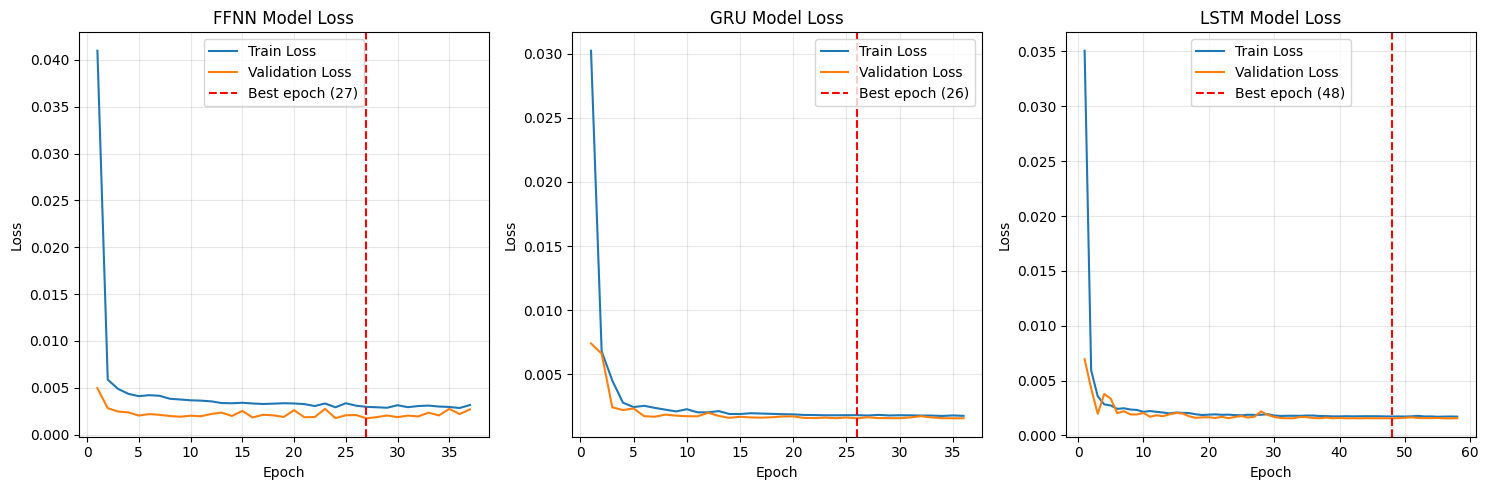

In [75]:
plt.figure(figsize=(15, 5))

# Plot FFNN losses
plt.subplot(1, 3, 1)
plt.plot(ffnn_history['epochs'], ffnn_history['train_loss'], label='Train Loss')
plt.plot(ffnn_history['epochs'], ffnn_history['val_loss'], label='Validation Loss')
plt.axvline(x=ffnn_history['best_epoch'], color='r', linestyle='--',
            label=f"Best epoch ({ffnn_history['best_epoch']})")
plt.title('FFNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot GRU losses
plt.subplot(1, 3, 2)
plt.plot(gru_history['epochs'], gru_history['train_loss'], label='Train Loss')
plt.plot(gru_history['epochs'], gru_history['val_loss'], label='Validation Loss')
plt.axvline(x=gru_history['best_epoch'], color='r', linestyle='--',
            label=f"Best epoch ({gru_history['best_epoch']})")
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot LSTM losses
plt.subplot(1, 3, 3)
plt.plot(lstm_history['epochs'], lstm_history['train_loss'], label='Train Loss')
plt.plot(lstm_history['epochs'], lstm_history['val_loss'], label='Validation Loss')
plt.axvline(x=lstm_history['best_epoch'], color='r', linestyle='--',
            label=f"Best epoch ({lstm_history['best_epoch']})")
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "training_history.png"))
plt.show()

## 4. Validate the model

Now that we have trained the models, and checked for possible issues around overfitting, we can start using these to make predictions.

To do so, we have created a simple function `predict_random_samples` which predicts the time series of `S` and `I` for random samples of beta and gamma combinations from a provided `SIRTimeSeriesDataset`. The function makes predictions for whichever models you pass, and from the predictions creates a data frame with the predictions as well as the equivalent ground-truth from the actual SIR model.

In [76]:
def predict_random_samples(models, dataset, model_names, num_samples=9, features=['beta', 'gamma'], targets=['S', 'I']):
    """
    Predicts the time series of S and I for random samples of beta and gamma combinations,
    compares to ground truth, and returns a DataFrame with predictions and ground truth.

    Args:
        models: List of trained models [FFNN, GRU, LSTM].
        dataset: The dataset containing the input features and target values.
        model_names: List of model names ["FFNN", "GRU", "LSTM"].
        num_samples: Number of random samples to generate (default: 9).
        features: List of feature names (default: ['beta', 'gamma']).
        targets: List of target names (default: ['S', 'I']).

    Returns:
        df_long: A Pandas DataFrame containing predictions, ground truth, and metadata.
    """
    all_predictions = []

    # Get unique beta and gamma combinations (ignoring replicates)
    unique_combinations = [tuple(param_set[:2]) for param_set in dataset.param_sets]  # Extract only beta and gamma
    unique_combinations = list(set(unique_combinations))  # Remove duplicates
    selected_combinations = random.sample(unique_combinations, num_samples)
    for model, model_name in zip(models, model_names):
      model.eval()  # Set model to evaluation mode
      for beta, gamma in selected_combinations:
        # Normalize features using the dataset's scaler
        features_values = np.array([beta, gamma])  # Create features array
        features_normalized = dataset.feature_scaler.transform(features_values.reshape(1, -1)).flatten()

        # Normalize features using the dataset's scaler
        features_normalized = dataset.feature_scaler.transform(features_values.reshape(1, -1)).flatten()

        # Create input tensor
        inputs = torch.tensor(features_normalized, dtype=torch.float32).unsqueeze(0).to(device)


        # Predict using the model
        with torch.no_grad():
            predictions = model(inputs).cpu().numpy().squeeze()

        # Store predictions and ground truth for each replicate
        for t in range(predictions.shape[0]):
            all_predictions.append({
                'model': model_name,  # Add model name
                **dict(zip(features, features_values)),
                **dict(zip(targets, predictions[t]*test_dataset.N)),
                't': t
            })

    # Create DataFrame for plotting
    df_predictions = pd.DataFrame(all_predictions)
    df_predictions = df_predictions.assign(replicate = 0)
    df_predictions = df_predictions.assign(N = test_dataset.N)
    df_predictions = df_predictions.assign(R = test_dataset.N - df_predictions["I"] - df_predictions["S"])

    # Create filtered of test_data
    filtered_test_data = dataset.dataframe[test_data[['beta', 'gamma']].apply(tuple, axis=1).isin(df_predictions[['beta', 'gamma']].apply(tuple, axis=1))]
    filtered_test_data = filtered_test_data.assign(model="TRUTH")
    # Combine
    df_combine = pd.concat([filtered_test_data, df_predictions])

    return df_combine



When we created our datasets, we kept one dataset back to be our test dataset, which will use here by selecting 9 random combinations of $\beta$ and $\gamma$ and creating the predictions of each model as well as the true SIR model runs.

In [77]:
df_predictions = predict_random_samples(
    models = [ffnn_model, gru_model, lstm_model],
    dataset = test_dataset,
    model_names = ["FFNN", "GRU", "LSTM"],
    num_samples = 9
    )

We can then wrangle this into long data and return to our beloved ggplot style for plotting the model predictions and the replicates of the stochastic SIR model.

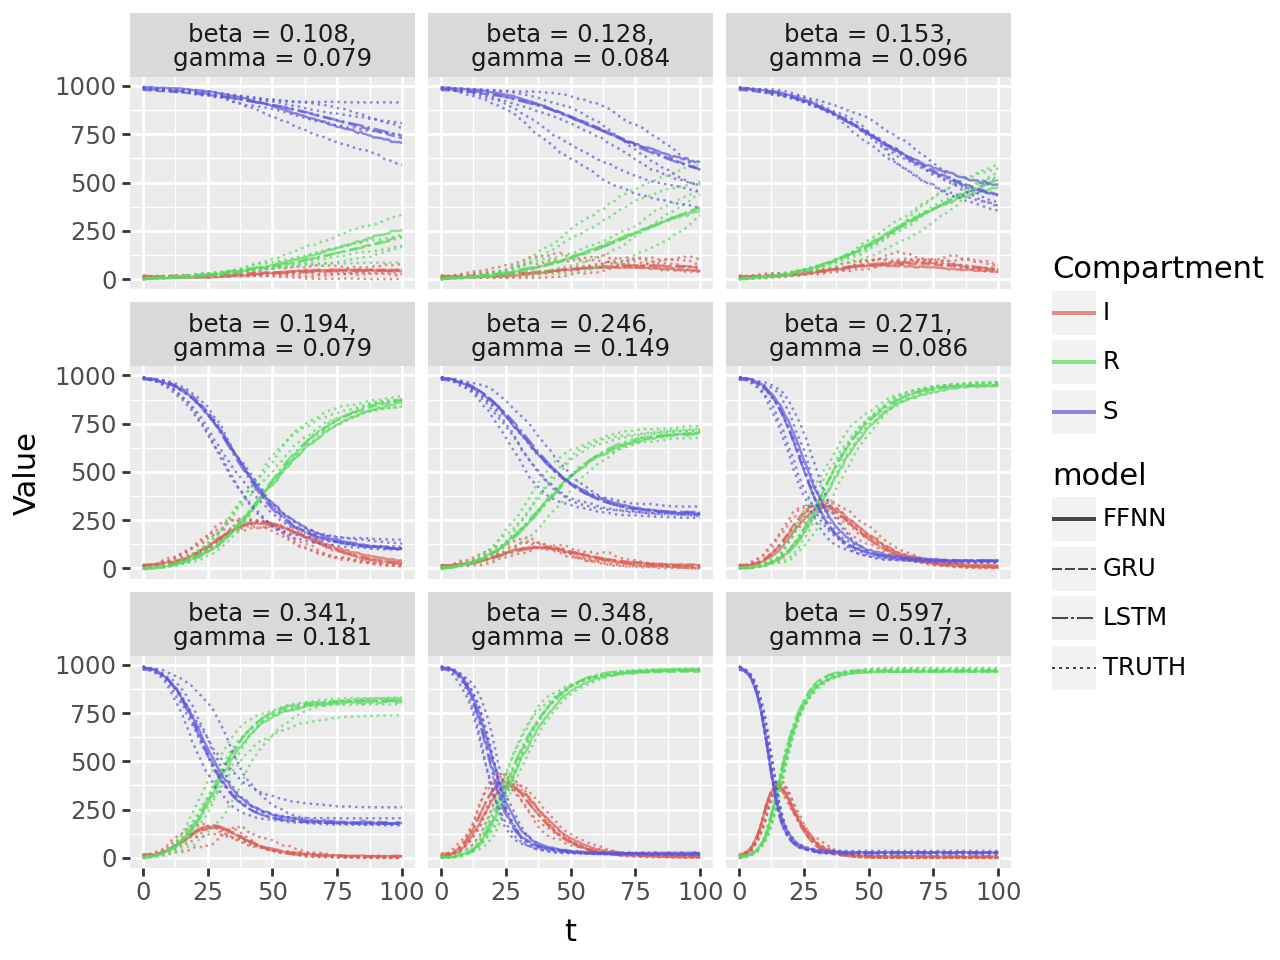

In [78]:
# Reshape dataframe into tidy long-format
df_long_preds = df_predictions.melt(
    id_vars=["t", "gamma", "beta", "replicate", "model"],  # Include model in id_vars
    value_vars=["S", "I", "R"],
    var_name="Compartment",
    value_name="Value",
)

# Add unique identifier for group plotting
df_long_preds = df_long_preds.assign(
    uid=df_long_preds["Compartment"]
    + df_long_preds["replicate"].astype(str)
    + df_long_preds["model"].astype(str)
)

# Add facet identifier for group plotting
df_long_preds = df_long_preds.assign(
    facet="beta = "
    + df_long_preds["beta"].round(3).astype(str)
    + ",\n"
    + "gamma = "
    + df_long_preds["gamma"].round(3).astype(str)
)

p = (
    ggplot(
        df_long_preds,
        aes(x="t", y="Value", group="uid", color="Compartment", linetype="model"),
    )
    + geom_line(alpha=0.7)
    + facet_wrap("facet")
)
ggplot.show(p)

## 5. Run the model

The section below will allow you to engage in a hands-on approach to actually using your trained emulator!

Eveyrthing that we have done so far looks good, however we've not actually shown you how to use the emulator, below we have written a little script that allows you to interface with the emulators you've trained and the SIR model such that you can visually see the outputs of your emulators in real time.

Have a go and try different parameter combinations, can you guess what will happen if you feed in a beta and gamma value that sits outside of the trained range?

In [ ]:
# Interactive section for testing model performance with custom parameters
import ipywidgets as widgets
from IPython.display import display, clear_output


def run_interactive_comparison(models, dataset, model_names):
    """
    Interactive widget to compare model predictions with actual SIR simulations
    for user-defined parameter values.
    """
    # Default values
    default_beta = 0.3
    default_gamma = 0.1

    # Create widgets
    beta_slider = widgets.FloatSlider(
        value=default_beta,
        min=0.05,
        max=0.8,
        step=0.01,
        description='Beta:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )

    gamma_slider = widgets.FloatSlider(
        value=default_gamma,
        min=0.05,
        max=0.8,
        step=0.01,
        description='Gamma:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )

    num_replicates_slider = widgets.IntSlider(
        value=10,
        min=1,
        max=100,
        step=1,
        description='Replicates:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
    )

    run_button = widgets.Button(
        description='Run Simulation',
        disabled=False,
        button_style='success',
        tooltip='Click to run the simulation',
        icon='play'
    )

    output = widgets.Output()

    def run_simulation(b):
        beta = beta_slider.value
        gamma = gamma_slider.value
        reps = num_replicates_slider.value

        with output:
            clear_output(wait=True)

            # Check if we're in a potentially unstable region
            if gamma > beta:
                print(f"⚠️ Warning: gamma ({gamma}) > beta ({beta}). This is outside the training distribution and may produce poor predictions.")

            # Run actual SIR model with these parameters
            print(f"Running SIR model with beta={beta}, gamma={gamma}, replicates={reps}")
            sir_results = run_model_with_replicates(beta=beta, gamma=gamma, reps=reps)

            # Normalize inputs for surrogate models
            features_values = np.array([beta, gamma])
            features_normalized = dataset.feature_scaler.transform(features_values.reshape(1, -1)).flatten()
            inputs = torch.tensor(features_normalized, dtype=torch.float32).unsqueeze(0).to(device)

            # Get predictions from all models
            model_predictions = {}
            for model, model_name in zip(models, model_names):
                model.eval()
                with torch.no_grad():
                    preds = model(inputs).cpu().numpy().squeeze()
                    # Convert to actual compartment values (S, I)
                    S_pred = preds[:, 0] * dataset.N
                    I_pred = preds[:, 1] * dataset.N
                    R_pred = dataset.N - S_pred - I_pred
                    model_predictions[model_name] = {
                        'S': S_pred,
                        'I': I_pred,
                        'R': R_pred
                    }

            # Create time points
            timepoints = dataset.timepoints

            # Plot results
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            compartments = ['S', 'I', 'R']
            colors = ['blue', 'red', 'green']

            for i, comp in enumerate(compartments):
                ax = axes[i]

                # Plot actual SIR results
                for r in range(reps):
                    replicate_data = sir_results[sir_results['replicate'] == r]
                    ax.plot(replicate_data['t'], replicate_data[comp],
                            'o', color=colors[i], alpha=0.3, markersize=3,
                            label=f'SIR {comp}' if r == 0 else None)

                # Plot model predictions
                for j, (model_name, preds) in enumerate(model_predictions.items()):
                    ax.plot(timepoints, preds[comp], '-',
                            label=f'{model_name} {comp}',
                            linewidth=2, alpha=0.8)

                ax.set_title(f'{comp} Compartment')
                ax.set_xlabel('Time')
                ax.set_ylabel('Population')
                ax.legend()
                ax.grid(alpha=0.3)

            plt.tight_layout()
            plt.show()

    run_button.on_click(run_simulation)

    # Create layout and display widgets
    display(widgets.VBox([
        widgets.HBox([beta_slider, gamma_slider]),
        widgets.HBox([num_replicates_slider, run_button]),
        output
    ]))

    # Run once with default values
    run_button.click()

# Run the interactive comparison
print("Use the sliders to change beta and gamma values, then click 'Run Simulation'")
print("Try setting gamma > beta to see how models perform outside their training distribution")
print("The models were trained with beta > gamma, so they may not generalize well to other scenarios")

run_interactive_comparison(
    models=[ffnn_model, gru_model, lstm_model],
    dataset=train_dataset,
    model_names=["FFNN", "GRU", "LSTM"]
)

## 6. Evaluate the model


Error metrics provide essential information about model performance. In epidemiological modeling, understanding how well our models predict disease spread under different transmission (beta) and recovery (gamma) parameters is crucial. The heatmaps we'll generate visualize performance across the parameter space, highlighting where models excel and where they struggle.
These standardized metrics (scaled from 0-1) allow for fair comparisons between different models and across different parameter combinations. Higher values (greener colors) always indicate better performance.

In essence, the code below systematically evaluates the accuracy of three different neural network models (FFNN, GRU, LSTM) in emulating an SIR epidemiological model. By generating high-resolution heatmaps, it visually compares their performance across a range of infection and recovery rates, providing valuable insights into the models' strengths and weaknesses in predicting disease dynamics, and how the performance varies across the parameter space that was used in training and that which is outside this space.

**Don't worry too much about this code, and focus on looking at the outputs and thinking about whether the results surprise you**

This analysis visualizes model performance across the parameter space with higher grid resolution.
For all metrics, higher values (greener) indicate better performance.

Using 20x20 grid (higher = smaller squares, but longer runtime)
Generating high-resolution standardized error heatmaps with 20x20 grid...
Progress: 5.0% complete (20/400 points). Time remaining: ~0.6 minutes
Progress: 10.0% complete (40/400 points). Time remaining: ~0.6 minutes
Progress: 15.0% complete (60/400 points). Time remaining: ~0.6 minutes
Progress: 20.0% complete (80/400 points). Time remaining: ~0.5 minutes
Progress: 25.0% complete (100/400 points). Time remaining: ~0.5 minutes
Progress: 30.0% complete (120/400 points). Time remaining: ~0.5 minutes
Progress: 35.0% complete (140/400 points). Time remaining: ~0.4 minutes
Progress: 40.0% complete (160/400 points). Time remaining: ~0.4 minutes
Progress: 45.0% complete (180/400 points). Time remaining: ~0.4 minutes
Progress: 50.0% complete (200/400 points). Time r

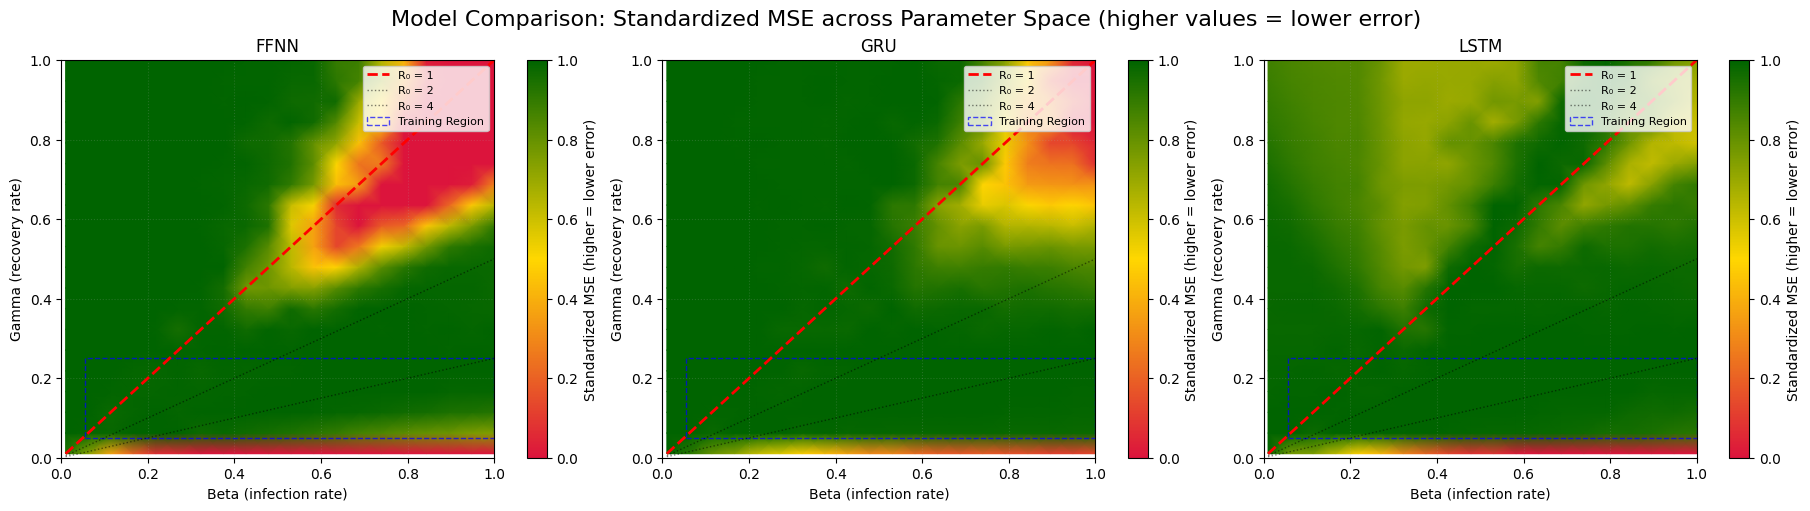

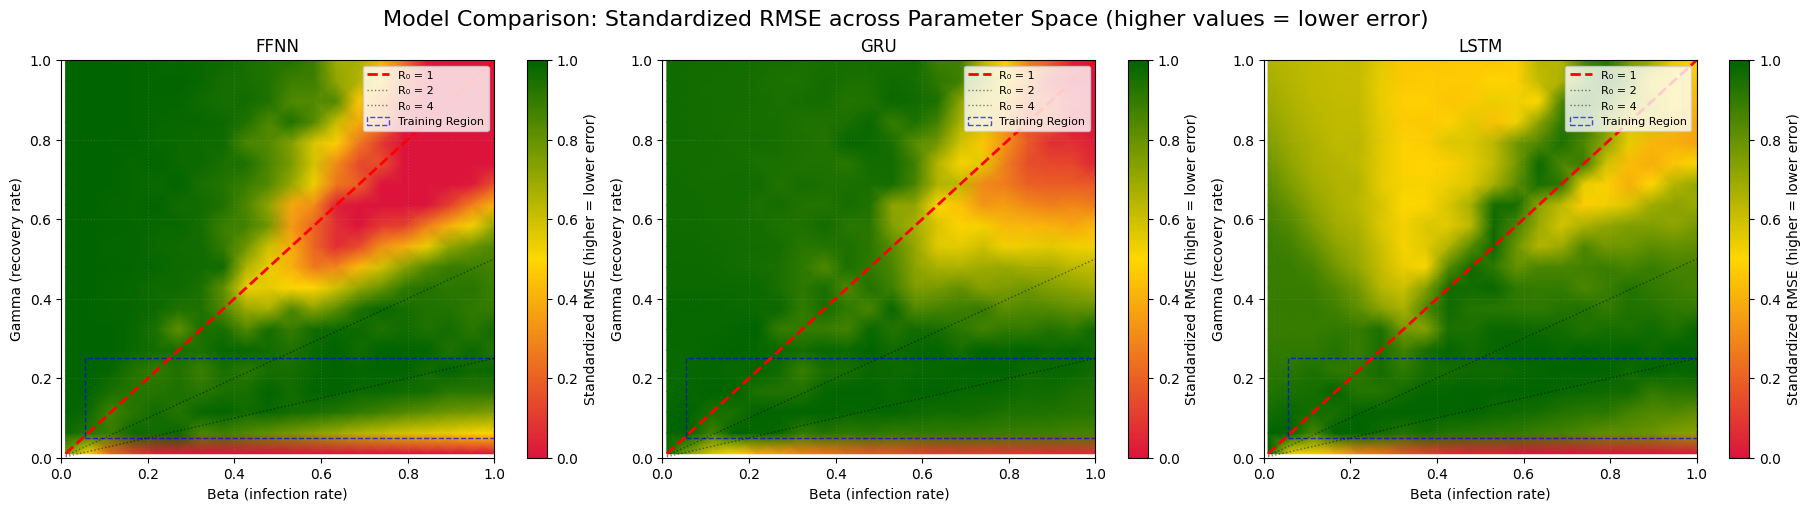

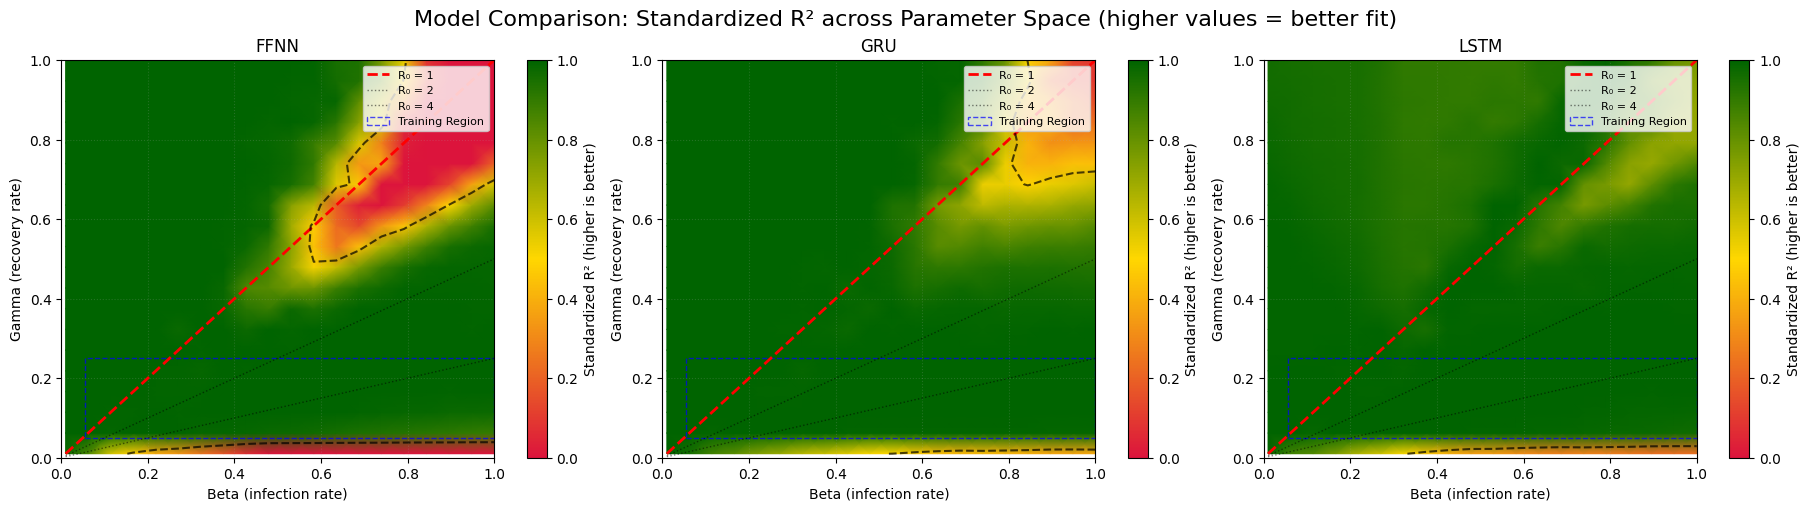

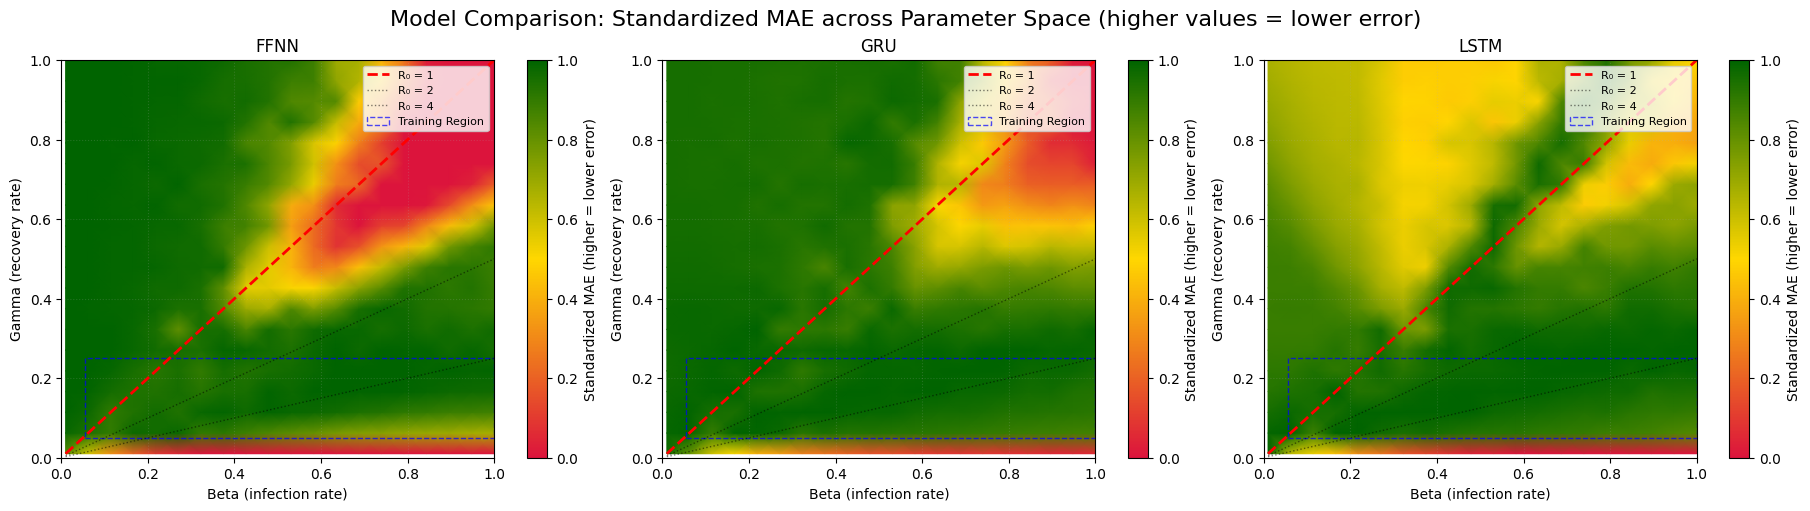

In [80]:
# Higher Resolution Standardized Error Metrics Heatmap
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap

def calculate_metrics(true_values, predicted_values):
    """Calculate multiple error metrics between true and predicted values."""
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)

    # For R², handle potential errors (R² can be negative if predictions are poor)
    try:
        r2 = r2_score(true_values, predicted_values)
        # Clip R² to prevent extreme negative values from skewing the heatmap
        r2 = max(r2, -1)
    except:
        r2 = -1

    return {
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae
    }

def plot_high_resolution_heatmaps(models, dataset, model_names, n_replicates=100, grid_resolution=20):
    """
    Generate error heatmaps across beta-gamma space with standardized metrics (0-1 scale)
    with one plot per metric and three panels per plot (one for each model).

    Parameters:
    -----------
    models : list
        List of trained models
    dataset : Dataset
        Dataset containing the input features and target values
    model_names : list
        List of model names as strings
    n_replicates : int
        Number of SIR model replicates to run for each parameter combination
    grid_resolution : int
        Number of grid points in each dimension (higher = smaller squares)
    """
    print(f"Generating high-resolution standardized error heatmaps with {grid_resolution}x{grid_resolution} grid...")
    start_time = time.time()

    # Define grid resolution (increased from previous 12x12)
    n_points = grid_resolution

    # Define beta and gamma ranges - extend to full 0-1 range
    # Starting slightly above 0 to avoid division by zero when calculating R0
    beta_values = np.linspace(0.01, 1.0, n_points)
    gamma_values = np.linspace(0.01, 1.0, n_points)

    # Create meshgrid for visualization
    beta_grid, gamma_grid = np.meshgrid(beta_values, gamma_values)

    # Define error metrics to track
    metrics = ['MSE', 'RMSE', 'R²', 'MAE']

    # Initialize error arrays - shape: (models, metrics, gamma_points, beta_points)
    error_grids = {
        model_name: {
            metric: np.zeros_like(beta_grid)
            for metric in metrics
        } for model_name in model_names
    }

    # Create a progress counter
    total_points = len(beta_values) * len(gamma_values)
    completed_points = 0

    # Track which points are outside the training distribution
    is_outside_training = np.zeros_like(beta_grid, dtype=bool)

    # Loop through each point in the grid
    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            # Check if this point is outside the typical training distribution
            is_outside_training[i, j] = (gamma > beta)

            # Run the actual SIR model with multiple replicates
            sir_results = run_model_with_replicates(beta=beta, gamma=gamma, reps=n_replicates)

            # Calculate mean of SIR replicates as ground truth
            sir_mean = sir_results.groupby('t').mean()[['S', 'I', 'R']].reset_index()

            # Normalize input for surrogate models
            features_values = np.array([beta, gamma])
            features_normalized = dataset.feature_scaler.transform(features_values.reshape(1, -1)).flatten()
            inputs = torch.tensor(features_normalized, dtype=torch.float32).unsqueeze(0).to(device)

            # Get predictions from each model
            for model, model_name in zip(models, model_names):
                model.eval()
                with torch.no_grad():
                    preds = model(inputs).cpu().numpy().squeeze()

                    # Convert to actual compartment values (S, I, R)
                    S_pred = preds[:, 0] * dataset.N
                    I_pred = preds[:, 1] * dataset.N
                    R_pred = dataset.N - S_pred - I_pred

                    # Combine all compartments for overall metrics
                    all_true = np.concatenate([sir_mean['S'], sir_mean['I'], sir_mean['R']])
                    all_pred = np.concatenate([S_pred, I_pred, R_pred])

                    # Calculate metrics
                    metrics_results = calculate_metrics(all_true, all_pred)

                    # Store in the error grids
                    for metric_name, metric_value in metrics_results.items():
                        error_grids[model_name][metric_name][i, j] = metric_value

            # Update progress
            completed_points += 1
            if completed_points % 20 == 0 or completed_points == total_points:
                elapsed = time.time() - start_time
                estimated_total = elapsed / completed_points * total_points
                remaining = estimated_total - elapsed
                percent_complete = 100 * completed_points / total_points
                print(f"Progress: {percent_complete:.1f}% complete ({completed_points}/{total_points} points). " +
                      f"Time remaining: ~{remaining/60:.1f} minutes")

    print(f"Heatmap generation completed in {(time.time() - start_time)/60:.2f} minutes")

    # Create a custom colormap (green for good, red for bad)
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['crimson', 'gold', 'darkgreen'])

    # Standardize metrics to 0-1 scale
    standardized_grids = {
        model_name: {
            metric: np.zeros_like(error_grids[model_name][metric])
            for metric in metrics
        } for model_name in model_names
    }

    # Process each metric
    for metric in metrics:
        # Collect all values for this metric across all models
        all_values = []
        for model_name in model_names:
            all_values.extend(error_grids[model_name][metric].flatten())

        # Get min and max for scaling (with protection against outliers)
        if metric == 'R²':
            # R² is already in a known range [-1, 1]
            # Transform to [0, 1] where 1 is best (highest R²)
            for model_name in model_names:
                standardized_grids[model_name][metric] = (error_grids[model_name][metric] + 1) / 2
        else:
            # For error metrics (MSE, RMSE, MAE), lower is better
            # Use percentiles to avoid extreme outliers
            min_val = np.percentile(all_values, 5)
            max_val = np.percentile(all_values, 95)

            # Transform to [0, 1] where 1 is best (lowest error)
            for model_name in model_names:
                normalized = (error_grids[model_name][metric] - min_val) / (max_val - min_val)
                # Clip to [0, 1] in case of values outside the percentile range
                normalized = np.clip(normalized, 0, 1)
                # Invert so that 1 means best performance (lowest error)
                standardized_grids[model_name][metric] = 1 - normalized

    # Calculate the min/max beta based on R0 and gamma (for plotting boundaries)
    min_beta = param_ranges["R0"][0] * param_ranges["gamma"][0]
    max_beta = param_ranges["R0"][1] * param_ranges["gamma"][1]

    # Create one figure per metric (with three panels for the models)
    for metric in metrics:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

        for n, model_name in enumerate(model_names):
            ax = axes[n]

            # Create the heatmap with standardized values
            # Use shading='gouraud' for smoother interpolation between grid cells
            im = ax.pcolormesh(beta_grid, gamma_grid, standardized_grids[model_name][metric],
                               cmap=custom_cmap,
                               vmin=0, vmax=1,
                               shading='gouraud')  # Use 'gouraud' for smooth interpolation

            # Add color bar
            cbar = fig.colorbar(im, ax=ax)
            if metric == 'R²':
                cbar.set_label(f'Standardized {metric} (higher is better)')
            else:
                cbar.set_label(f'Standardized {metric} (higher = lower error)')

            # Add R0 = 1 line (where beta = gamma)
            ax.plot(beta_values, beta_values, 'r--', linewidth=2, label='R₀ = 1')

            # Add contour lines for R0 values
            for r0 in [2, 4]:
                r0_gamma = beta_values / r0
                valid_idx = r0_gamma <= np.max(gamma_values)
                if any(valid_idx):
                    ax.plot(beta_values[valid_idx], r0_gamma[valid_idx],
                            'k:', linewidth=1, alpha=0.5, label=f'R₀ = {r0}')

            # Add training region boundary (using calculated beta values)
            ax.add_patch(plt.Rectangle(
                (min_beta, param_ranges["gamma"][0]),
                max_beta - min_beta,
                param_ranges["gamma"][1] - param_ranges["gamma"][0],
                fill=False, edgecolor='blue', linestyle='--', alpha=0.7,
                label='Training Region'))

            # Set labels and title
            ax.set_xlabel('Beta (infection rate)')
            ax.set_ylabel('Gamma (recovery rate)')
            ax.set_title(f'{model_name}')

            # Set equal limits from 0 to 1 for both axes
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)

            # Add grid
            ax.grid(alpha=0.2, linestyle=':')

            # Add legend
            ax.legend(loc='upper right', fontsize=8)

            # For R², show the original R² = 0 contour
            if metric == 'R²':
                # R² = 0 corresponds to standardized value of 0.5
                ax.contour(beta_grid, gamma_grid, standardized_grids[model_name][metric],
                          levels=[0.5], colors=['k'], linewidths=1.5, alpha=0.7,
                          linestyles='dashed')

        # Main title for the figure
        if metric == 'R²':
            metric_description = "(higher values = better fit)"
        else:
            metric_description = "(higher values = lower error)"

        fig.suptitle(f'Model Comparison: Standardized {metric} across Parameter Space {metric_description}',
                    fontsize=16)

        # Save figure
        plt.savefig(os.path.join(output_dir, f"high_res_error_{metric}.png"), dpi=150)
        plt.show()

# Run the high-resolution analysis
print("This analysis visualizes model performance across the parameter space with higher grid resolution.")
print("For all metrics, higher values (greener) indicate better performance.")
print("\nWarning: Higher resolution means more computations and longer runtime.")

# Prompt user for desired resolution
resolution = 20  # Default resolution
print(f"Using {resolution}x{resolution} grid (higher = smaller squares, but longer runtime)")

try:
    plot_high_resolution_heatmaps(
        models=[ffnn_model, gru_model, lstm_model],
        dataset=train_dataset,
        model_names=["FFNN", "GRU", "LSTM"],
        n_replicates=5,  # Reduced from 10 to save time with higher resolution
        grid_resolution=resolution
    )

except Exception as e:
    print(f"Error generating high-resolution error heatmaps: {e}")
    import traceback
    traceback.print_exc()

When looking at the heatmap above, think through these 3 questions to help guide your thinking:

> **1. Do the patterns of model performance across the beta-gamma parameter space make intuitive sense given your understanding of SIR dynamics?** For example, are there regions where all models perform well or poorly? If so, how do those regions relate to the basic reproductive number (R0), which is influenced by beta and gamma? Can you explain why certain parameter combinations might be more challenging for the models to predict accurately?

> **2. What specific features or boundaries can you identify in the heatmaps, and how might they be linked to the underlying SIR model or the training data used for the neural networks?** Do you notice any sharp transitions in performance, or regions where one model significantly outperforms others? How might these features relate to the training region boundary, the line representing R0 = 1, or the contour lines for different R0 values? Is the training region shown with the blue box correct? Is this the entire region that it was trained on, and if not not does this explain the heatmap patterns?

> **3. Considering the overall performance visualized in the heatmaps, which model appears to be the most robust and reliable surrogate for the SIR model across a wide range of parameter values?** What specific evidence from the heatmaps supports your conclusion? Are there scenarios or parameter ranges where a particular model might be preferred over others, and why? How might you use these insights to make informed decisions about model selection for future epidemiological studies or simulations?

## Conclusion

In this notebook, we explored the process of building and training deep learning surrogates for infectious disease modeling using the SIR model as an example. We covered the following key steps:

1. **Data Generation:** We used the `emidm` package to simulate SIR model dynamics with varying parameters using Latin Hypercube Sampling (LHS) to systematically explore the parameter space and generate training, validation, and test datasets.

2. **Data Preparation:** We created a custom PyTorch `Dataset` class (`SIRTimeSeriesDataset`) to efficiently handle the time series data and implemented `DataLoader` for batch processing during training.

3. **Model Building and Training:** We defined and trained three different neural network architectures:
   - **Feedforward Neural Network (FFNN):** A basic neural network with multiple layers.
   - **Gated Recurrent Unit (GRU):** A recurrent neural network designed for sequential data.
   - **Long Short-Term Memory (LSTM):** Another recurrent neural network with more complex gating mechanisms.
   We trained these models using the Adam optimizer and a learning rate scheduler, monitoring their performance on validation data to prevent overfitting.
   - We also applied a sigmoid activation function to the final layer of each model to ensure the predictions were bound between 0 and 1 and included normalization.

4. **Model Validation:** We assessed the trained models' performance by predicting on a held-out test dataset and comparing the predictions to the ground truth SIR model simulations.

5. **Visualization:** We visualized the training history, showing the training and validation losses over epochs, and highlighted the best-performing epochs for each model.

## Extensions for Further Exploration

If you've completed the main sections of this notebook and have some extra time, consider exploring these extensions to deepen your understanding of surrogate modeling.

### 1. Hyperparameter Tuning

**Challenge:** Experiment with different hyperparameters of the neural network models (e.g., hidden size, number of layers, dropout rate, learning rate) to see how they affect performance.

**Hint:** Use a grid search or random search approach to systematically explore different hyperparameter combinations and evaluate their impact on validation loss.

**Code Snippet (Grid Search Example):**

```python
import itertools

# Define hyperparameter ranges
hidden_sizes = [32, 64, 128]
num_layers = [1, 2, 3]
dropout_rates = [0.1, 0.2, 0.3]

# Create all possible combinations
hyperparameter_combinations = list(itertools.product(hidden_sizes, num_layers, dropout_rates))

# Loop through combinations and train models
for hidden_size, num_layers, dropout_rate in hyperparameter_combinations:

# Create and train model with current hyperparameters
# ...

```

### 2. Capturing Stochastic Uncertainty

**Challenge:** Modify the models to predict the variance in stochastic replicates over time, rather than just the point estimate. This can be used to create a surrogate that captures stochastic uncertainty, providing a more comprehensive representation of the SIR model's behavior.

**Hint:** Instead of predicting only the mean values of S and I, train the models to predict both the mean and variance (or standard deviation) for each time step. You'll need to adjust the output layer of the models and modify the loss function to account for both mean and variance predictions. You can consider using metrics like the negative log-likelihood (NLL) for evaluating the performance of models predicting distributions.

**Code Snippet (Modifying the FFNN model):**
```python
class FFNN(nn.Module):

    def forward(self, x):
        # Output now includes both mean and variance
        output = self.network(x)
        output = output.view(-1, self.time_steps, self.output_channels, 2)
        mean = self.sigmoid(output[:, :, :, 0])
        variance = self.softplus(output[:, :, :, 1])  
        return mean, variance
```

> Further Hint: Instead of predicting only the mean values of S and I, train the models to predict both the mean and variance (or standard deviation) for each time step. You'll need to adjust the output layer of the models and modify the loss function to account for both mean and variance predictions. **Importantly, you'll also need to change the SIRTimeSeriesDataset class to ensure that all stochastic replicates for a given parameter set are available during training, as the model now needs to learn the distribution of outcomes.** You can consider using metrics like the negative log-likelihood (NLL) for evaluating the performance of models predicting distributions.

### 3. Surrogate-Assisted Inference

**Challenge:** Use the trained surrogate model to perform tasks like parameter estimation or sensitivity analysis, which are typically computationally expensive with the original SIR model.

**Hint:** You can use optimization algorithms to find parameter values that minimize the difference between the surrogate's predictions and observed data. For parameter estimation, you can define an objective function that calculates the loss between the surrogate's predictions and the observed data for a given set of parameters. Then, use an optimization algorithm like `scipy.optimize.minimize` to find the parameter values that minimize this loss. For sensitivity analysis, you can vary the input parameters of the surrogate model and observe the corresponding changes in the output to understand the model's sensitivity to different parameters.

**Code Snippet (Parameter Estimation):**

```python
scipy.optimize import minimize

def objective_function(params, surrogate_model, observed_data):
  # ... (calculate surrogate predictions using params) ...
  # ... (calculate difference between predictions and observed_data) ...
  return loss

# Perform optimization
result = minimize(objective_function, initial_params, args=(surrogate_model, observed_data))
```

> > Further Hint: You can generate your own observed data by simulating an SIR epidemic using the functions from `emidm`. Or you could get data from a real outbreak from [https://www.reconverse.org/outbreaks/](https://www.reconverse.org/outbreaks/), e.g. the outbreak of influenza A (H1N1) in 1978 at a British boarding school of 763 children and changing your data generation to use a different `N`.